In [1]:
import torch

attn_path = '/root/tqdm/work_dirs/infer_debug/exp_224_eva02_sneotTrue_patchfpn_noprompt/x2021_0223_1756/1620322699293_attn.pt'
attn_weights_new = torch.load(attn_path, map_location="cpu")
print(attn_weights_new.keys() if isinstance(attn_weights_new, dict) else type(attn_weights_new))

/root/miniconda3/envs/tqdm_py310/lib/python3.10/site-packages/torch/cuda/__init__.py:51: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


dict_keys(['rgb'])


In [2]:
attn_weights_new['rgb'].keys()

dict_keys(['attn_weights', 'spatial_shapes'])

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def visualize_multi_scale_attention(
    attn_weights_new, 
    layer_idx=0,        # 对应 attn_weights_new['rgb']['attn_weights'][layer_idx]
    batch_idx=0,        # 第几张图片
    cls_idx=0,          # 第几个类别 (0或1)
    target_size=(224, 224), 
    save_path=None,     # 如果不为None，则保存为图片
    show_plot=True,     # 是否在Jupyter中显示
    cmap='jet'          # 热力图颜色映射
):
    """
    可视化多尺度注意力图函数
    
    参数:
        attn_weights_new (dict): 包含 'spatial_shapes' 和 'attn_weights' 的数据字典
        layer_idx (int): Transformer Encoder 的层索引 (0, 1, 2...)
        batch_idx (int): Batch 中的图片索引
        cls_idx (int): 类别索引 (通常 0: 背景/类别A, 1: 类别B)
        target_size (tuple): 统一缩放的目标尺寸 (H, W)
        save_path (str): 图片保存路径 (如 'vis.png')。如果为 None 则不保存。
        show_plot (bool): 是否使用 matplotlib 显示结果
    """
    
    # 1. 获取空间尺寸信息
    spatial_shapes = attn_weights_new['rgb']['spatial_shapes']
    spatial_sizes = [s[0].item() * s[1].item() for s in spatial_shapes]
    # 计算累积索引 [0, 14*14, 14*14+28*28, ...]
    cumsum_sizes = [0] + list(torch.tensor(spatial_sizes).cumsum(0).numpy())
    
    # 2. 提取指定层 (Layer) 的 Attention Tensor
    # 原始形状通常是 [Batch, Num_Heads, Total_Tokens, Num_Classes]
    # 根据您的代码逻辑，这里似乎取的是 [0] (第一个head?) 或者是直接 squeeze 掉的维度
    # 假设结构为 list -> tensor
    raw_attn_tensor = attn_weights_new['rgb']['attn_weights'][layer_idx]
    
    # 兼容性处理：如果有多头维度 (Batch, Heads, Tokens, Classes)，通常我们取平均或取第一个头
    # 这里严格照抄您的逻辑: [0][0] -> 取第一个元素，再取第一个元素
    # 如果您的结构是 list(tensor(B, N, L, C))，请根据实际情况调整下面这行
    # 根据您的代码片段：attn_weights_new['rgb']['attn_weights'][0][0]
    # 我们假设 raw_attn_tensor 已经是 [Batch, Total_Tokens, Num_Classes] 或类似结构
    # 但根据您的 snippet，似乎是 raw_attn_tensor[0]... 
    
    # --- 修正提取逻辑以匹配您的 snippet ---
    # 假设输入结构是标准 Deformable DETR 输出
    source_tensor = raw_attn_tensor[0] # 对应您的 attn_weights_new['rgb']['attn_weights'][0][0] 的第一个[0]
    
    vis_data = [] # 存储处理好的 numpy 图像
    
    # 3. 循环处理每个尺度 (Level)
    for idx, (h, w) in enumerate(spatial_shapes):
        h, w = h.item(), w.item()
        start_idx = cumsum_sizes[idx]
        end_idx = cumsum_sizes[idx + 1]
        
        # 3.1 切片提取当前 Level 的 tokens
        # 形状: (B, Tokens_level, K) -> (B, h*w, K)
        # 您的代码逻辑：[:, start_idx:end_idx, :]
        attn_level_tokens = source_tensor[:, start_idx:end_idx, :]
        
        # 3.2 Reshape 成空间特征图
        # (B, h, w, K)
        attn_level_spatial = attn_level_tokens.reshape(-1, h, w, attn_level_tokens.shape[-1])
        
        # 3.3 提取指定 Batch 和 指定 Class
        # attn_level_spatial: [Batch, H, W, Class]
        # 取 batch_idx, cls_idx
        attn_map = attn_level_spatial[batch_idx, :, :, cls_idx] # Shape: (h, w)
        
        # 3.4 归一化 (Normalization) - 关键！
        # 必须在 resize 之前做，或者在 resize 之后做，但必须是对单张图做
        a_min, a_max = attn_map.min(), attn_map.max()
        if (a_max - a_min) > 1e-8:
            attn_norm = (attn_map - a_min) / (a_max - a_min)
        else:
            attn_norm = attn_map
            
        # 3.5 上采样 (Resize)
        # F.interpolate 需要 (B, C, H, W)
        attn_norm = attn_norm.unsqueeze(0).unsqueeze(0)
        attn_resized = F.interpolate(
            attn_norm, 
            size=target_size, 
            mode='bilinear', 
            align_corners=False
        )
        
        # 转回 numpy (H, W)
        attn_numpy = attn_resized.squeeze().detach().cpu().numpy()
        vis_data.append({
            'name': f"Level {idx}",
            'shape': f"{h}x{w}",
            'data': attn_numpy
        })

    # ================= 4. 可视化逻辑 =================
    
    # A. Matplotlib 显示 (Jupyter 专用)
    if show_plot:
        num_levels = len(vis_data)
        fig, axes = plt.subplots(1, num_levels, figsize=(5 * num_levels, 5))
        if num_levels == 1: axes = [axes]
        
        for ax, item in zip(axes, vis_data):
            im = ax.imshow(item['data'], cmap=cmap)
            ax.set_title(f"{item['name']}\nOrigin: {item['shape']}", fontsize=12)
            ax.axis('off')
        
        # 添加共用 Colorbar
        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        plt.suptitle(f"Layer {layer_idx} | Batch {batch_idx} | Class {cls_idx}", fontsize=14)
        plt.show()

    # B. OpenCV 保存 (保存到本地文件)
    if save_path:
        cv2_images = []
        for item in vis_data:
            # 转换为 0-255 uint8
            img_uint8 = (item['data'] * 255).astype(np.uint8)
            # 应用伪彩色 (注意: OpenCV 默认 BGR，Matplotlib 默认 RGB)
            # COLORMAP_JET 对应 plt 的 'jet'
            heatmap = cv2.applyColorMap(img_uint8, cv2.COLORMAP_JET)
            
            # 添加文字标签
            label = f"{item['name']} ({item['shape']})"
            cv2.putText(heatmap, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, (255, 255, 255), 2, cv2.LINE_AA)
            cv2_images.append(heatmap)
            
        # 横向拼接
        if cv2_images:
            combined_img = cv2.hconcat(cv2_images)
            # 确保目录存在
            save_dir = os.path.dirname(save_path)
            if save_dir and not os.path.exists(save_dir):
                os.makedirs(save_dir)
            cv2.imwrite(save_path, combined_img)
            print(f"Visualization saved to: {save_path}")

# ================= 使用示例 =================
# 假设 attn_weights_new 已经存在
# visualize_multi_scale_attention(
#     attn_weights_new, 
#     layer_idx=0,    # 取第0层
#     batch_idx=0,    # 取Batch中第0张图
#     cls_idx=0,      # 取第1个类别
#     save_path="result_vis.png" # 同时保存图片
# )

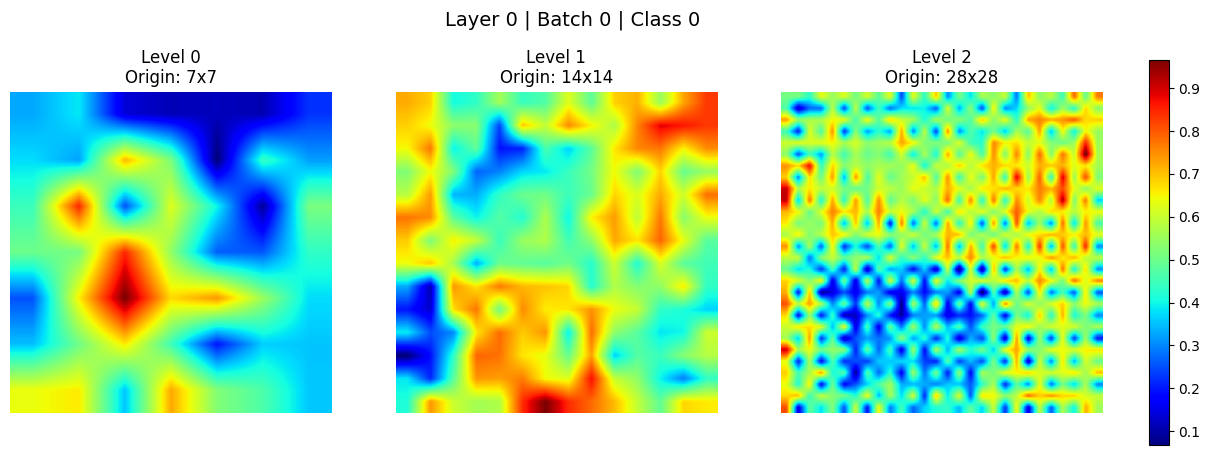

Visualization saved to: result_vis.png


In [21]:
visualize_multi_scale_attention(
    attn_weights_new, 
    layer_idx=0,    # 取第0层
    batch_idx=0,    # 取Batch中第0张图
    cls_idx=0,      # 取第1个类别
    save_path="result_vis.png" # 同时保存图片
)

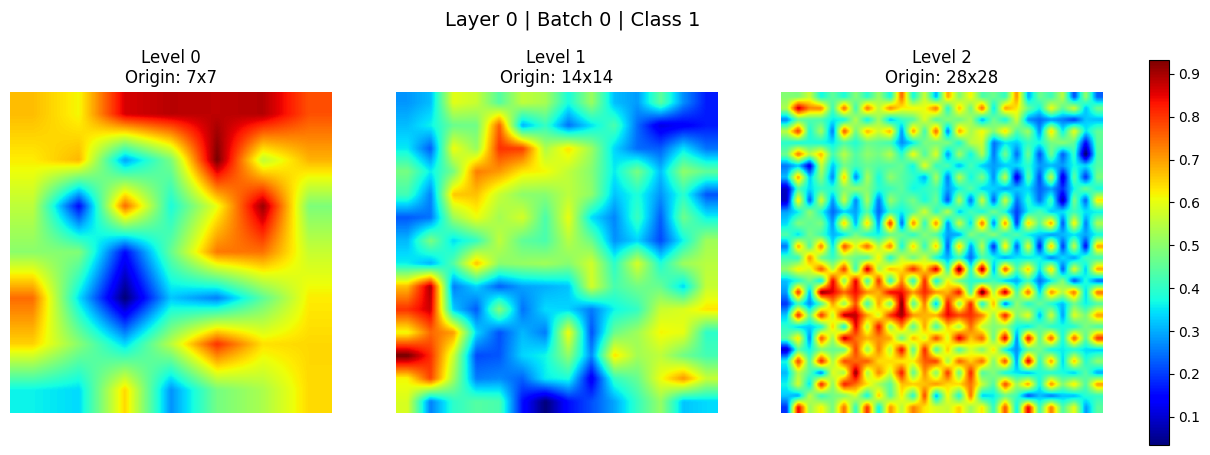

Visualization saved to: result_vis.png


In [22]:
visualize_multi_scale_attention(
    attn_weights_new, 
    layer_idx=0,    # 取第0层
    batch_idx=0,    # 取Batch中第0张图
    cls_idx=1,      # 取第1个类别
    save_path="result_vis.png" # 同时保存图片
)

In [24]:
len(attn_weights_new['rgb']['attn_weights'])

6